In [1]:
import numpy as np
from pyDOE import lhs
#from simulation1Day import simulation, hypoGlicemia, hyperGlicemia, pidC1
from scipy.integrate import odeint
#from hovorka import modelPID

In [2]:
def modelPID(x, t, Kp, Ki, Kd):
    w = 100
    ka1 = 0.006  #
    ka2 = 0.06  #
    ka3 = 0.03  #
    kb1 = 0.0034  #
    kb2 = 0.056  #
    kb3 = 0.024  #
    u_b = 0.0555
    tmaxI = 55  #
    VI = 0.12 * w  #
    ke = 0.138  #
    k12 = 0.066  #
    VG = 0.16 * w  #
    # G = Q1 / VG
    F01 = 0.0097 * w  #
    FR = 0
    EGP0 = 0.0161 * w  #
    AG = 0.8  #
    Gmolar = 180.1559
    tmaxG = 40  #
    sp = 110 * VG / 18

    Q1, Q2, S1, S2, I, x1, x2, x3, tau, Dg, Ie, u = x
    dQ1 = - F01 - x1 * Q1 + k12 * Q2 - FR + EGP0 * (1 - x3) + (x[9] * AG * 1000 / Gmolar) * tau * np.exp(
        -tau / tmaxG) / (tmaxG ** 2)
    dQ2 = x1 * Q1 - (k12 + x2) * Q2
    dIe = sp - Q1
    de = - dQ1
    uNew = max(Ki * Ie + Kp * dIe + Kd * de, 0)
    dS1 = uNew + u_b - S1 / tmaxI
    dS2 = (S1 - S2) / tmaxI
    dI = S2 / (tmaxI * VI) - ke * I
    dx1 = - ka1 * x1 + kb1 * I
    dx2 = - ka2 * x2 + kb2 * I
    dx3 = - ka3 * x3 + kb3 * I
    dtau = 1
    dDg = 0
    dxdt = [dQ1, dQ2, dS1, dS2, dI, dx1, dx2, dx3, dtau, dDg, dIe, uNew - u]

    return dxdt

In [3]:
def simulation(timeOfMeals, dGs, model):
    ttot = [0]
    ytot = [97.77, 19.08024, 3.0525, 3.0525, 0.033551, 0.01899, 0.03128, 0.02681, 0.0, 0, 0, 0]
    x0 = ytot
    for i in range(len(timeOfMeals)):
        x0[8] = 0
        x0[9] = dGs[i]
        time = np.arange(0, timeOfMeals[i], 0.2)
        #t = timeOfMeals[i]
        y = odeint(model, x0, time)
        x0 = y[-1, :]
        ytot = np.vstack([ytot, y])
        ttot = np.hstack([ttot, time + ttot[-1]])
    return ttot, ytot


Kd = [0, -0.0602, -0.0573, -0.06002, -0.0624]
Ki = [0, -3.53e-07, -3e-07, -1.17e-07, -7.55e-07]
Kp = [0, -6.17e-04, -6.39e-04, -6.76e-04, -5.42e-04]

pidC1 = lambda x, t: modelPID(x, t, Kp[1], Ki[1], Kd[1])
pidC2 = lambda x, t: modelPID(x, t, Kp[2], Ki[2], Kd[2])
pidC3 = lambda x, t: modelPID(x, t, Kp[3], Ki[3], Kd[3])
pidC4 = lambda x, t: modelPID(x, t, Kp[4], Ki[4], Kd[4])

pidC1Noise = lambda x, t: modelPID(x, t, Kp[1], Ki[1], Kd[1])
pidC2Noise = lambda x, t: modelPID(x, t, Kp[2], Ki[2], Kd[2])
pidC3Noise= lambda x, t: modelPID(x, t, Kp[3], Ki[3], Kd[3])
pidC4Noise= lambda x, t: modelPID(x, t, Kp[4], Ki[4], Kd[4])


# pid5 = lambda x, t: modelPID(x, t, -0.1, 0, -0.1)
# pid6 = lambda x, t: modelPID(x, t, -5.12720526e-04, -1.16330231e-06, -6.54656447e-02)
# pid7 = lambda x, t: modelPID(x, t, -6.16146031e-04, -3.90083101e-07, -6.75289141e-02)

In [4]:
t_meal1 = np.random.normal(300, 60)
t_meal2 = np.random.normal(300, 60)
t_meal3 = 1440 - t_meal1 - t_meal2
dg1 = np.random.normal(40, 10)
dg2 = np.random.normal(90, 10)
dg3 = np.random.normal(60, 10)

t, y = simulation([t_meal1, t_meal2, t_meal3], [dg1, dg2, dg3], pidC3)
y = y[:,0];

No handles with labels found to put in legend.


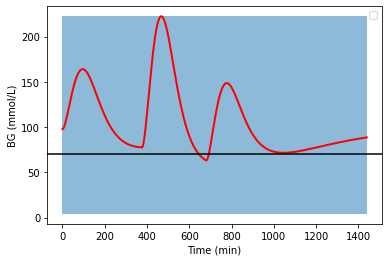

In [6]:
# plot results

import matplotlib.pyplot as plt

thresholdUp = 180;
thresholdDown = 70;

plt.fill_between([t[0],t[-1]], [4,4],[max(y),max(y)],alpha=0.5)
plt.plot(t,y,'r-',linewidth=2)
plt.axhline(y=thresholdDown, color='k', linestyle='-')
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('BG (mmol/L)')
plt.show()

In [7]:
# NON TOCCARE!!!!

# # Import module
# # https://blog.notmyidea.org/using-jpype-to-bridge-python-and-java.html

# import jpype

# # Enable Java imports
# import jpype.imports

# # Pull in types
# from jpype.types import *

# # Launch the JVM
# jpype.startJVM(jpype.getDefaultJVMPath(),"-ea", "-Djava.class.path=jar/moonlight.jar")

# from java.lang import System
# print(System.getProperty("java.class.path"))

# script = """monitor BooleanMonitorScript {
# signal { real x; real y;}
# domain boolean;
# formula globally [0, 0.2]  #[ x > y ]#;
# }
# monitor QuantitativeMonitorScript{
# signal { real x; real y;}
# domain minmax;
# formula globally [0, 0.2] #[ x - y ]#;
# }"""
# a = jpype.JPackage("eu").quanticol.moonlight.xtext.ScriptLoader()
# b = a.compileScript(script)
# c = b.selectTemporalComponent("QuantitativeMonitorScript")
# time = JArray(JDouble)([1,2])
# space = JArray(JDouble,2)([[1,2],[1,2]])
# aa = c.monitorToDoubleArray(time,space,None)
# #s = a.getClassName(JString("a"))
# aa

In [8]:
import jpype
from jpype import JArray,JDouble
jpype.startJVM(jpype.getDefaultJVMPath(),"-ea", "-Djava.class.path={}".format("jar/moonlight.jar"))


class Moonlight:
    
#     def __init__(self, jar_location="jar/moonlight.jar"):
#         self.jar_location = jar_location
        
#     def startJVM(self):
#         jpype.startJVM(jpype.getDefaultJVMPath(),"-ea", "-Djava.class.path={}".format(self.jar_location))
        
    def setScript(self, script):
        script_loader = jpype.JPackage("eu").quanticol.moonlight.xtext.ScriptLoader()
        self.compiled_script = script_loader.compileScript(script)
    
    def get_monitor(self, monitor_name):
        monitor = self.compiled_script.temporal()
        return monitor.selectTemporalComponent(monitor_name)

class Monitor:
    
     def __init__(self,moonlight_monitor):
            self.monitor = moonlight_monitor
     
     def monitor(self, time, space, parameters=None):
            monitor = self.monitor
            return monitor.monitorToArray(time,space,parameters)  

/Users/lauranenzi/opt/anaconda3/lib/python3.7/site-packages/jpype/_core.py:217: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [9]:
script = """
signal {real y;}
domain minmax; 
formula hypoGlicemia = globally [0, 1400]  (y > 70);
formula hyperGlicemia = globally [0, 1400]  (y < 180);
"""

moonlight = Moonlight()
#moonlight.startJVM()
moonlight.setScript(script)
monitor = moonlight.get_monitor("future")

time = JArray(JDouble)(t)
values = JArray(JDouble)(y)
result = np.array(monitor.monitorToArray(time,values))
result

TypeError: No matching overloads found for io.github.moonlightsuite.moonlight.TemporalScriptComponent.monitorToArray(double[],double[]), options are:
	public double[][] io.github.moonlightsuite.moonlight.TemporalScriptComponent.monitorToArray(double[],java.lang.String[][],java.lang.String[])
	public double[][] io.github.moonlightsuite.moonlight.TemporalScriptComponent.monitorToArray(io.github.moonlightsuite.moonlight.signal.Signal,double[])
	public double[][] io.github.moonlightsuite.moonlight.TemporalScriptComponent.monitorToArray(io.github.moonlightsuite.moonlight.signal.Signal,java.lang.String[])
	public double[][] io.github.moonlightsuite.moonlight.TemporalScriptComponent.monitorToArray(double[],double[][],double[])

